# Simulate workers at a call center processing calls

Current constraints:
1. One shift of workers
2. Every call takes the same amount of time
3. Workers do not take breaks

Free parameters:
1. Number of workers
2. How long each call takes
3. How long callers will hold for before hanging up

Goal:
- Determine which calls were processed successfully and which were missed

In [1]:
from collections import defaultdict

from datetime import date
from datetime import datetime
from datetime import time
from datetime import timedelta

from itertools import product

from queue import Queue
from queue import LifoQueue
from queue import PriorityQueue


from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Read all individual call events

In [2]:
def read_calls(fname):
    calls = []
    with open(fname, "r") as fin:
        for line in fin:
            line = line.rstrip("\n")
            
            # use time.fromisoformat() in future (python 3.7+)
            hour, minute, second = map(int, line.split(":"))
            calls.append(time(hour=hour, minute=minute, second=second))
            
    return calls

### Generate call stack

In [3]:
def get_call_stack(call_list):
    call_stack = LifoQueue()
    for call in reversed(call_list):
        call_stack.put(call)
        
    return call_stack

## Perform simulation with the given constraints

In [4]:
def simulate(num_workers, call_length, hold_time, call_stack):
    """Simulate a call center.
    
    Constraints:
        - one shift of workers
        - every call takes the same amount of time
        - workers do not take breaks

    Arguments:
        - num_workers: how many call center workers
        - call_length: how long each call takes
        - hold_time: how long will hold before hanging up
        - call_stack: sorted stack of call times rounded to the nearest second

    Returns:
        - number of successfully processed calls
        - list of missed calls
    """

    assert num_workers > 0, "Must have at least one worker"    
    assert isinstance(call_length, timedelta)
    assert isinstance(hold_time, timedelta)
    assert isinstance(call_stack, LifoQueue)


    TIME_RESOLUTION = timedelta(seconds=1)

    # when the workers start and stop working
    START_TIME = time(hour=5, minute=0)
    END_TIME = time(hour=22, minute=30)

    #--------------------------------------------------------------------------

    cur_time = datetime.combine(date.min, START_TIME)
    stop_time = datetime.combine(date.min, END_TIME)


    hold_line = Queue() # callers who are on hold because all agents are busy

    # agents who are not currently busy with callers
    free_workers = Queue()
    for i in range(num_workers):
        free_workers.put(i)

    # when workers finish processing a call, when the call came in, and the worker id
    work_line = PriorityQueue()

    
    num_successful_calls = 0
    missed_calls = []

    while cur_time < stop_time:

        # add new callers to wait queue
        while not call_stack.empty():
            new_call = call_stack.get()

            new_call_datetime = datetime.combine(date.min, new_call)

            if cur_time == new_call_datetime:
                hold_line.put(new_call)
            else:
                assert cur_time < new_call_datetime

                call_stack.put(new_call)
                break


        # free up any workers who are done
        while not work_line.empty():
            work_endtime, call_intime, worker_id = work_line.get()
            
            if cur_time < work_endtime:
                work_line.put((work_endtime, call_intime, worker_id))
                break
            else:
                assert cur_time == work_endtime

                num_successful_calls += 1
                free_workers.put(worker_id)


        # assign free workers to new callers
        while not free_workers.empty() and not hold_line.empty():
            worker_id = free_workers.get()
            call_intime = hold_line.get()

            if datetime.combine(date.min, call_intime) + hold_time < cur_time:
                # caller hung up before we could process them
                free_workers.put(worker_id) # workers get cycled, which is not a perfect simulation
                missed_calls.append(call_intime)
            else:
                finish_datetime = cur_time + call_length

                work_line.put((finish_datetime, call_intime, worker_id))


        cur_time += TIME_RESOLUTION    

    #---------------------------------------------------------------
        
    assert call_stack.qsize() == 0
    
    while not hold_line.empty():
        call_time = hold_line.get()
        missed_calls.append(call_time)
        
    while not work_line.empty():
        work_etime, call_intime, worker_id = work_line.get()
        missed_calls.append(call_intime)
        
    return (num_successful_calls, sorted(missed_calls))

---

In [5]:
def call_loss_summary(missed_calls):
    """Summarize when we missed calls based on a list
    of times of when the calls arrived."""

    intimes = (
        datetime.combine(date.today(), intime)
        for intime in missed_calls
    )
    
    failed = (pd
        .DataFrame(intimes, columns=["call_intime"])
        .assign(num_missed = 1)
    )
    
    return (failed
        .groupby(pd.Grouper(key="call_intime", freq="30T"))
        .sum()
    )

In [6]:
def final_summary(call_volume_fname, missed_calls):
    assert isinstance(missed_calls, pd.DataFrame)

    call_vol = pd.read_csv(call_volume_fname, sep='\t')
    
    call_vol = call_vol.assign(
        call_intime = pd.to_datetime(call_vol["start_time"])
    )
    
    return (call_vol
        .merge(
            missed_calls.reset_index(),
            how="left", on="call_intime"
        )
        .drop("call_intime", axis=1)
        .fillna(0)
        .assign(num_missed = lambda df: df["num_missed"].astype(int))
    )

---

## Examine performance for different number of workers

In [7]:
def param_set(min_talk, max_talk):
    for hold_time, call_length in product([10, 20, 30], range(min_talk, max_talk+1)):
        yield (hold_time, call_length)

In [8]:
# go until all done or some max number (to prevent infinite loops)

MAX_WORKERS = 40
MIN_TALK_TIME_MINUTES = 3
MAX_TALK_TIME_MINUTES = 6

call_times_fname = "data/call_times_uniform.txt"
call_list = read_calls(call_times_fname)

TOTAL_CALLS = len(call_list)

res = defaultdict(list)


for hold_time, call_length in tqdm(param_set(MIN_TALK_TIME_MINUTES, MAX_TALK_TIME_MINUTES), total=12):

    for num_workers in range(1, MAX_WORKERS+1):
        # need a new stack each time because it gets modified
        call_stack = get_call_stack(call_list)

        num_successful, failed = simulate(
            num_workers, timedelta(minutes=call_length),
            timedelta(seconds=hold_time), call_stack
        )

        res["num_workers"].append(num_workers)
        res["num_successful"].append(num_successful)
        res["call_length_mins"].append(call_length)
        res["hold_time_secs"].append(hold_time)

        if num_successful == TOTAL_CALLS:
            break

res = pd.DataFrame(res)

100%|██████████| 12/12 [03:20<00:00, 18.17s/it]


---

## Simulation results

In [9]:
res.head()

,num_workers,num_successful,call_length_mins,hold_time_secs
0,1,305,3,10
1,2,585,3,10
2,3,840,3,10
3,4,1078,3,10
4,5,1312,3,10


In [10]:
res.shape

(211, 4)

---

In [11]:
TOTAL_CALLS

2350

In [12]:
fres = res.assign(
    pct_success = lambda df: df["num_successful"].divide(TOTAL_CALLS).multiply(100)
)

In [13]:
fres.head()

,num_workers,num_successful,call_length_mins,hold_time_secs,pct_success
0,1,305,3,10,12.978723
1,2,585,3,10,24.893617
2,3,840,3,10,35.744681
3,4,1078,3,10,45.872340
4,5,1312,3,10,55.829787


---

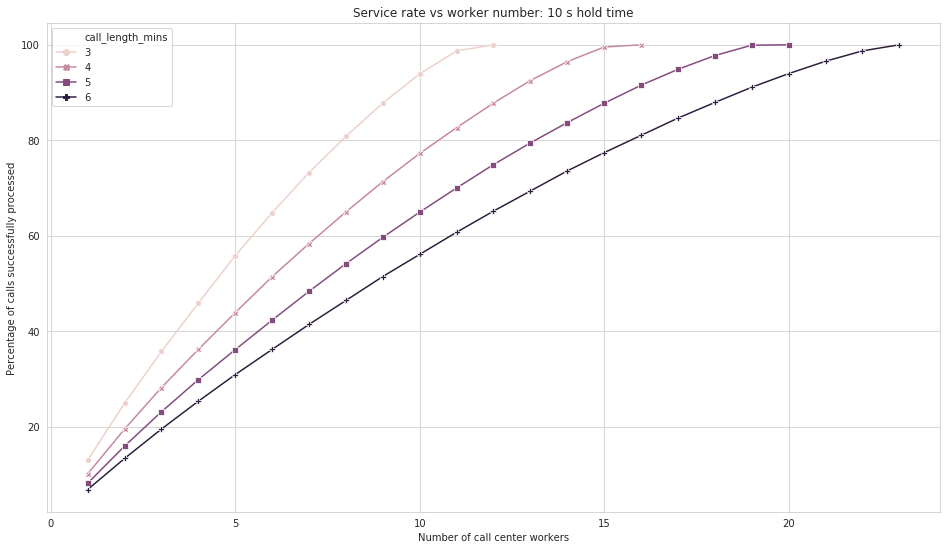

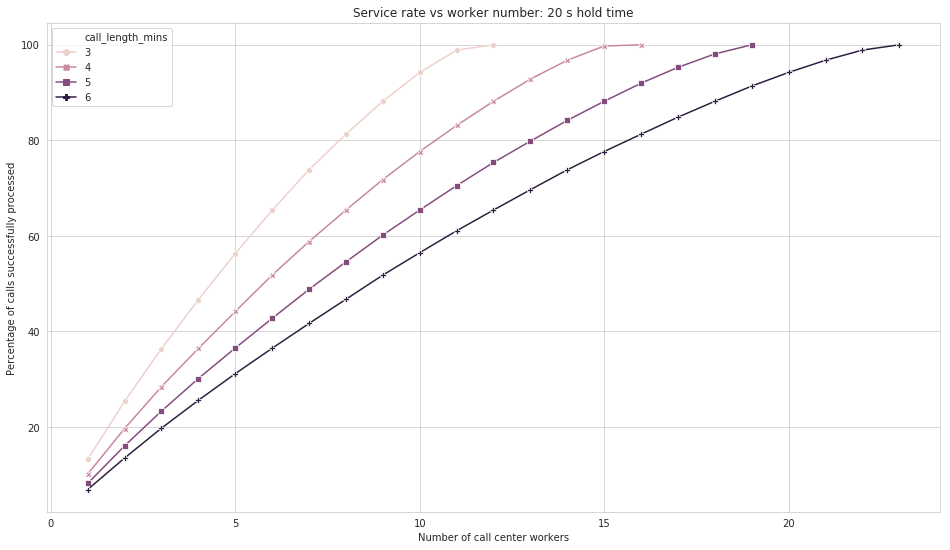

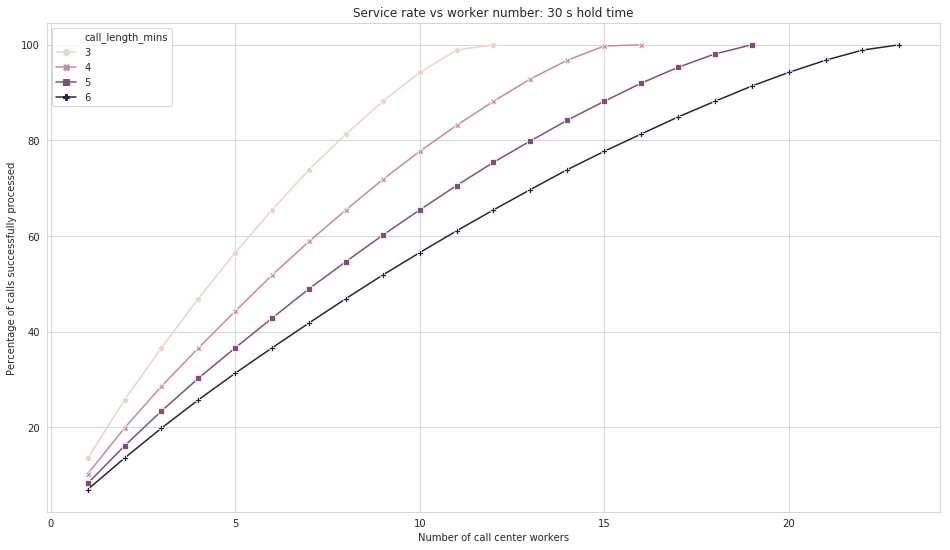

In [14]:
sns.set_style("whitegrid")

for hold_time, df in fres.groupby("hold_time_secs"):
    
    plt.figure(figsize=(16, 9), facecolor="white")

    ax = sns.lineplot(
        data=df, x="num_workers", y="pct_success",
        hue="call_length_mins", markers=True, style="call_length_mins", dashes=False
    )

    ax.set_xlabel("Number of call center workers")
    ax.set_ylabel("Percentage of calls successfully processed")

    ax.set_title("Service rate vs worker number: {} s hold time".format(hold_time))